In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import peakutils
import IPython.display

from scipy.signal import chebwin, savgol_filter
from scipy.io import wavfile

from listen.audio.segmentation import segments
# from listen.spectrogram.spectrogram import Spectrogram
# from listen.data.librispeech import librispeech
from listen.data.an4 import an4

an4data = an4.AN4(conversion=False, debug=False)

# spg = Spectrogram(fft_size=2048, step_size=128, thresh=400)
train = list(an4data.trainset)
ch = random.choice(range(len(train)))
# ch = 331
samples, t = train[ch]
# samples,t = librispeech.load_data(dev=True)[15]
# samples = 'D:\\theyenaman\\Dropbox\\code\\python\\ml_project\\listen\\data\\librispeech\\LibriSpeech\\dev-clean\\84\\121123\\84-121123-0020.wav'
rate, data = wavfile.read(samples)
# min_duration = int((1000 * len(data) / rate) / (20 * len(t) + 20))
min_duration = 15
print("Duration (estimated):", min_duration)
zcr = np.zeros_like(data)
wsize = (rate * min_duration) // 1000

for i in range(len(zcr) - wsize - 1):
    zcr[i] = np.sum(np.abs(np.sign(data[i:i+wsize]) - np.sign(data[i+1:i+wsize+1])))

window = chebwin(wsize, at=100)
# Smooth zcr
for i in range(len(zcr) - wsize):
    zcr[i] = np.mean(zcr[i:i+wsize] * window)

es = segments(data, rate, min_duration=min_duration, alpha=0)

es[np.isnan(es)] = 0
# Estimate data baseline
l = len(es) // 20
r = 19 * l

es = es[l:r]
zcr = zcr[l:r]

es = es / np.max(es)
zcr = zcr / np.max(zcr)

me = np.max(es)
be = np.mean(es) / me
se = np.std(es) / me
te = be

mz = np.max(zcr)
bz = np.mean(zcr) / mz
sz = np.std(zcr) / mz
tz = bz
# zcr = savgol_filter(np.sign(np.diff(zcr)), wsize + 1, 1)
# zcr[zcr < 0] = 0
print("Stats for es:\tmean={:.4}, std={:.4f},thresh={:.4}".format(be, se, te))
print("Stats for zcr:\tmean={:.4f}, std={:.4f},thresh={:.4}".format(bz, sz, tz))
print("Utterance:\tindex={}\n\t\ttranscript={}".format(ch, t))
indices = peakutils.peak.indexes(es, min_dist=wsize, thres=te)
zcidx = peakutils.peak.indexes(zcr, min_dist=wsize, thres=0.3)

Duration (estimated): 15
Stats for es:	mean=0.4569, std=0.1280,thresh=0.4569
Stats for zcr:	mean=0.2169, std=0.2231,thresh=0.2169
Utterance:	index=842
		transcript=['EIGHT', 'FORTY', 'ONE']


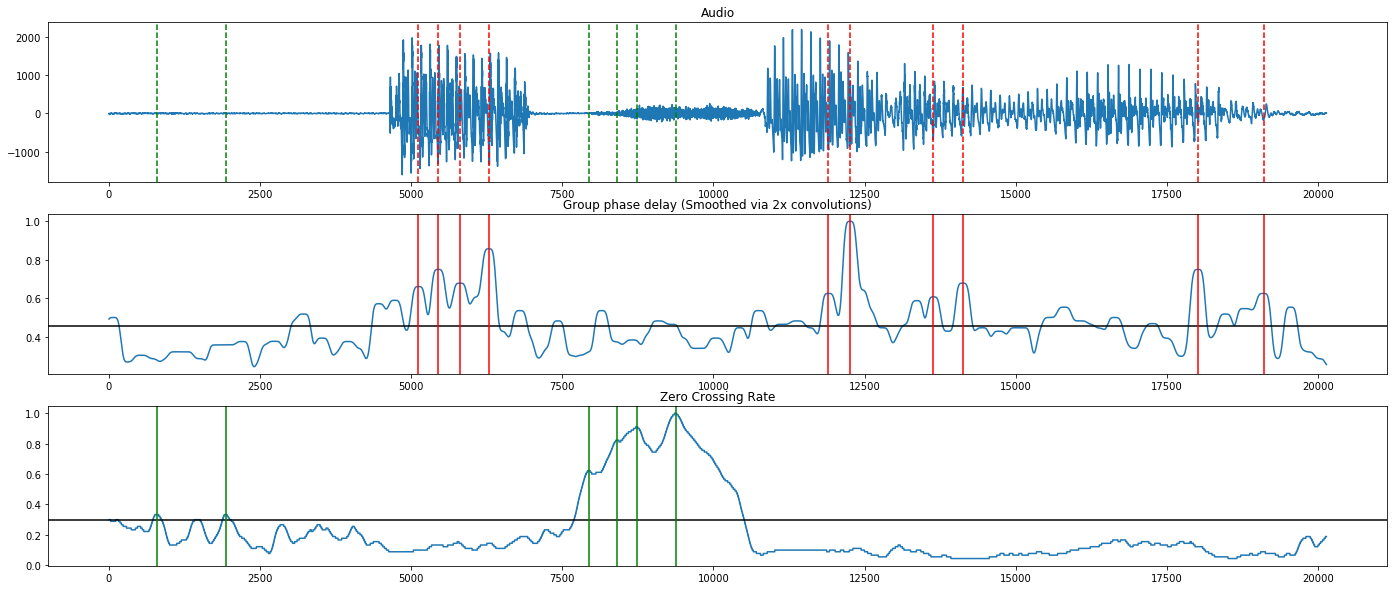

In [2]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(24, 10))
ax[0].plot(data[l:r])
ax[0].set_title('Audio')
ax[1].plot(es)
ax[1].axhline(y=te, color='black')
ax[1].set_title('Group phase delay (Smoothed via 2x convolutions)')

ax[2].plot(zcr)
ax[2].axhline(y=0.3*np.max(zcr), color='black')
ax[2].set_title('Zero Crossing Rate')

for idx in indices:
    ax[0].axvline(x=idx, color='red', linestyle='dashed')
    ax[1].axvline(x=idx, color='red')
for idx in zcidx:
    ax[0].axvline(x=idx, color='green', linestyle='dashed')
    ax[2].axvline(x=idx, color='green')
plt.show()
IPython.display.Audio(data=data, rate=rate)